# Imports

In [72]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingWarmRestarts
sys.path.append('../src')
from modules import (
                    paths,
                    dataset,
                    model,
                    utils,
                    acdc,
                    train
                    )
from torchvision.transforms import v2
from torch.optim import AdamW

# Globals

These variables decide what running this notebook does:
- Toy: Uses toy datasets, very small, just for testing purposes
- Train_base: trains the baseline
- run_acdc: Performs ACDC on the baseline for different values of Tau
- benchmark: Tests all the found circuits loggin accuracy and speed
- train_pruned: Trains the pruned ViT 

In [73]:
toy=False
train_base = False
run_acdc = False
benchmark = False
train_pruned = False

# Data

Transformatiions applied on Train/Validation Data

In [74]:
transform_train = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.RandomErasing(p=0.25),

])

transform_valid = v2.Compose([
    v2.Lambda(lambda x: x.convert('RGB')),  # some images are in grayscale
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [75]:
import importlib
importlib.reload(dataset)
if toy == True:
    print("laoding toy datasets")
    train_dataset, coarse_labels = dataset.load_animal_dataset("train", tiny=True, stop=6)
    val_dataset, coarse_labels = dataset.load_animal_dataset("valid", tiny=True, stop=2)

else:
    print("loading full dataet")
    train_dataset, coarse_labels = dataset.load_animal_dataset("train")
    val_dataset, coarse_labels = dataset.load_animal_dataset("valid")

train_dataset = dataset.TorchDatasetWrapper(train_dataset, transform=transform_train)
val_dataset = dataset.TorchDatasetWrapper(val_dataset, transform=transform_valid)
print("train:\n"+str(train_dataset))
print("validation:\n"+str(val_dataset))


loading full dataet
Loading animal dataset from /home/lexyo/Dev/cv-proj2/notebooks/../data/animal_train.pkl
Loading animal dataset from /home/lexyo/Dev/cv-proj2/notebooks/../data/animal_valid.pkl
train:
Dataset({
    features: ['image', 'label'],
    num_rows: 29000
})
validation:
Dataset({
    features: ['image', 'label'],
    num_rows: 2900
})


In [76]:
batch_size = 5 if toy else 4096 

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,  
    pin_memory=True,
    prefetch_factor=8,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,  
    pin_memory=True,
    prefetch_factor=8,
    persistent_workers=True
)

# Train Baseline

In [77]:
importlib.reload(model)
config = {
    "patch_size": 8,           # Kept small for fine-grained patches
    "hidden_size": 64,          # Increased from 48 (better representation)
    "num_hidden_layers": 6,     # Deeper for pruning flexibility
    "num_attention_heads": 8,   # More heads (head_dim = 64/8 = 8)
    "intermediate_size": 4 * 64,# Standard FFN scaling
    "hidden_dropout_prob": 0.2, # Mild dropout for regularization
    "attention_probs_dropout_prob": 0.2,
    "initializer_range": 0.02,
    "image_size": 64,
    "num_classes": 58,
    "num_channels": 3,
    "qkv_bias": True,           # Keep bias for now (can prune later)
}

importlib.reload(train)

class SoftTargetCrossEntropy(nn.Module):
    """Cross-entropy loss compatible with Mixup/Cutmix soft labels"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x, target):
        # x = model outputs (logits)
        # target = mixed labels (probability distributions)
        loss = torch.sum(-target * F.log_softmax(x, dim=1), dim=1)
        return loss.mean()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vit = model.ViT(config).to(device)

num_epochs = 500
warmup_epochs = 20
base_lr = 3e-4
min_lr = 1e-6
weight_decay = 0.05  # For AdamW optimizer
label_smoothing = 0.1  # For cross-entropy
patience = 50



optimizer = AdamW(vit.parameters(),
                  lr=base_lr,
                  weight_decay = weight_decay,
                  betas=(0.9, 0.98),
                  eps = 1e-6      
                  )

# Linear warmup for 30 epochs (0 → base_lr)
warmup = LinearLR(
    optimizer,
    start_factor=1e-6,  # Near-zero initial LR
    end_factor=1.0,     # Full LR after warmup
    total_iters=warmup_epochs,
)

cosine = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=num_epochs - warmup_epochs,  
    eta_min=min_lr,
)

# Combine them
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup, cosine],
    milestones=[warmup_epochs], 
)

mixup_fn = v2.MixUp(
    alpha=1.0,          
    num_classes=58
)


In [78]:
cg_before_pruning = utils.ComputationalGraph(vit)

In [79]:
if train_base:
    trainer = train.Trainer(model=vit,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            optimizer=optimizer,
                            criterion=SoftTargetCrossEntropy(),
                            val_criterion=nn.CrossEntropyLoss(),
                            scheduler=scheduler,
                            device = device,
                            writer=torch.utils.tensorboard.SummaryWriter(log_dir=paths.logs),
                            scaler=torch.amp.GradScaler(),
                            num_epochs=num_epochs,
                            log_interval=50,
                            model_dir=paths.chekpoints,
                            mixup_fn=mixup_fn,
                            early_stop_patience=patience,
                            model_name="vit1.pth",
                            resume=False
                            )
    acc = trainer.train()
else:
    acdc.load_checkpoint(vit, paths.chekpoints / "vit1.pth", device)

# ACDC

In [80]:
importlib.reload(acdc)
importlib.reload(dataset)
acdc_dataset = dataset.ContrastiveWrapper(val_dataset, coarse_labels)

acdc_loader = DataLoader(
    acdc_dataset,
    batch_size=50,
    shuffle=False,
    num_workers= 8 if device == torch.device("cuda") else 1,  
    pin_memory= True if device == torch.device("cuda") else False,
    prefetch_factor= 8 if device == torch.device("cuda") else 1,  
    collate_fn=dataset.contrastive_collate_fn,
    persistent_workers= True if device == torch.device("cuda") else False,
)
clean_batch, corrupted_batch = next(iter(acdc_loader))


Indexing dataset by class for contrastive sampling...
Indexing complete.


In [81]:
importlib.reload(acdc)
importlib.reload(utils)
if run_acdc:
    circuits = {}
    for tau in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        circuits[str(tau)] = acdc.run_ACDC_optimized(vit, tau, acdc_loader, device=device)
else:
    cirtcuits_paths = paths.chekpoints / "circuits0001.pkl"
    import pickle
    circuits = pickle.load(open(cirtcuits_paths, "rb"))
    cirtcuits_paths = paths.chekpoints / "circuits.pkl"
    circuits = circuits | pickle.load(open(cirtcuits_paths, "rb"))
    print(circuits.keys())

dict_keys(['0.001', '0.002', '0.003', '0.004', '0.0001', '0.0005', '0.005', '0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])


In [82]:
if benchmark == True:
    if device == torch.device("cpu"): val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    acdc.test_taus(circuits, val_loader, coarse_labels, config, device)
else:
    if device == torch.device("cuda"):
        with open(paths.data/"benchmark rtx4000ADA.txt", 'r') as f:
            data = f.read()
            print(data)
    else:
        with open(paths.data/"benchmark ryzen74700u.txt", 'r') as f:
            data = f.read()
            print(data)

Testing model with tau 0.001
Pruning 0 unused MLP layers...
Pruning 7 unused attention heads...

Model pruned. Ready for retraining on the circuit.
Accuracy: 60.13793103448276 | Avg Time over 10 runs: 6.606388831138611 seconds

Testing model with tau 0.002
Pruning 0 unused MLP layers...
Pruning 14 unused attention heads...

Model pruned. Ready for retraining on the circuit.
Accuracy: 56.96551724137931 | Avg Time over 10 runs: 6.501619791984558 seconds

Testing model with tau 0.003
Pruning 0 unused MLP layers...
Pruning 18 unused attention heads...

Model pruned. Ready for retraining on the circuit.
Accuracy: 56.10344827586207 | Avg Time over 10 runs: 5.169708943367004 seconds

Testing model with tau 0.004
Pruning 0 unused MLP layers...
Pruning 18 unused attention heads...

Model pruned. Ready for retraining on the circuit.
Accuracy: 56.10344827586207 | Avg Time over 10 runs: 5.18979434967041 seconds

Testing model with tau 0.0001
Pruning 0 unused MLP layers...
Pruning 0 unused attentio

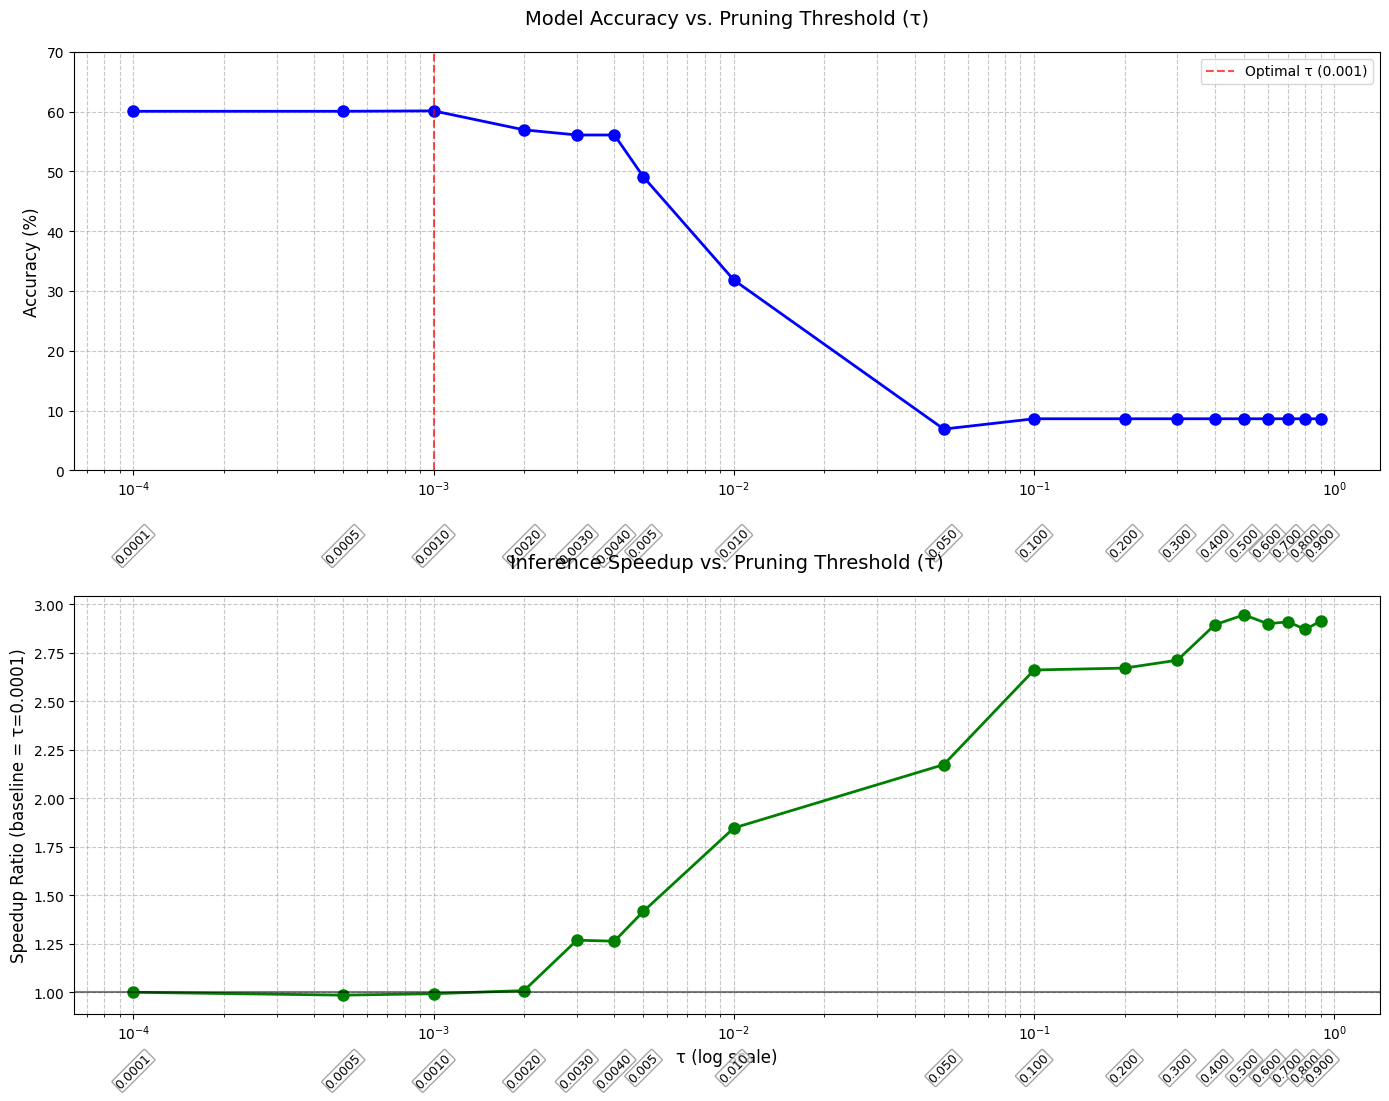

In [83]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def tau_formatter(x, pos):
    if x < 0.0005:
        return f'{x:.4f}'
    elif x < 0.005:
        return f'{x:.4f}'
    else:
        return f'{x:.3f}'

def parse_results(text):
    taus = []
    accuracies = []
    times = []
    
    # Extract data using regular expressions
    tau_matches = re.findall(r'Testing model with tau ([\d.]+)', text)
    accuracy_matches = re.findall(r'Accuracy: ([\d.]+)', text)
    time_matches = re.findall(r'Avg Time over 10 runs: ([\d.]+) seconds', text)
    
    # Convert extracted strings to numbers
    taus = [float(tau) for tau in tau_matches]
    accuracies = [float(acc) for acc in accuracy_matches]
    times = [float(t) for t in time_matches]
    
    # Find baseline time (tau=0.0001)
    baseline_index = taus.index(0.0001)
    baseline_time = times[baseline_index]
    
    # Calculate speedup ratios
    speedups = [baseline_time / t for t in times]
    
    # Sort all data by tau values
    sorted_indices = np.argsort(taus)
    taus_sorted = np.array(taus)[sorted_indices]
    accuracies_sorted = np.array(accuracies)[sorted_indices]
    speedups_sorted = np.array(speedups)[sorted_indices]
    
    return taus_sorted, accuracies_sorted, speedups_sorted

def plot_graphs(taus, accuracies, speedups):
    plt.figure(figsize=(14, 12))
    
    # Custom formatter for tau values
    def tau_formatter(x, pos):
        if x < 0.0005:
            return f'{x:.4f}'
        elif x < 0.005:
            return f'{x:.4f}'
        else:
            return f'{x:.3f}'
    
    # Accuracy vs Tau plot
    ax1 = plt.subplot(2, 1, 1)
    plt.semilogx(taus, accuracies, 'bo-', linewidth=2, markersize=8)
    plt.title('Model Accuracy vs. Pruning Threshold (τ)', fontsize=14, pad=20)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.axvline(x=0.001, color='r', linestyle='--', alpha=0.7, 
                label='Optimal τ (0.001)')
    plt.legend()
    plt.ylim(0, 70)
    
    # Add tau values below points
    for tau, acc in zip(taus, accuracies):
        plt.annotate(tau_formatter(tau, None), 
                    xy=(tau, 0), 
                    xytext=(0, -40), 
                    textcoords='offset points',
                    ha='center', va='top', 
                    rotation=45, fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="gray", alpha=0.7))
    
    # Speedup vs Tau plot
    ax2 = plt.subplot(2, 1, 2)
    plt.semilogx(taus, speedups, 'go-', linewidth=2, markersize=8)
    plt.title('Inference Speedup vs. Pruning Threshold (τ)', fontsize=14, pad=20)
    plt.xlabel('τ (log scale)', fontsize=12)
    plt.ylabel('Speedup Ratio (baseline = τ=0.0001)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.axhline(y=1, color='k', linestyle='-', alpha=0.5)
    
    # Add tau values below points
    min_speedup = min(speedups)
    for tau, spd in zip(taus, speedups):
        plt.annotate(tau_formatter(tau, None), 
                    xy=(tau, min_speedup), 
                    xytext=(0, -40), 
                    textcoords='offset points',
                    ha='center', va='top', 
                    rotation=45, fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="gray", alpha=0.7))
    
    # Adjust layout to make room for labels
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, hspace=0.3)
    
    plt.savefig('pruning_analysis_with_tau_labels.png', dpi=300, bbox_inches='tight')
    plt.show()

if device == torch.device("cuda"):
    with open(paths.data/"benchmark rtx4000ADA.txt", 'r') as f:
        data = f.read()
else:
    with open(paths.data/"benchmark ryzen74700u.txt", 'r') as f:
        data = f.read()
    
taus, accuracies, speedups = parse_results(data)
plot_graphs(taus, accuracies, speedups)

# Train pruned

In [86]:
importlib.reload(model)
config = {
    "patch_size": 8,           # Kept small for fine-grained patches
    "hidden_size": 64,          # Increased from 48 (better representation)
    "num_hidden_layers": 6,     # Deeper for pruning flexibility
    "num_attention_heads": 8,   # More heads (head_dim = 64/8 = 8)
    "intermediate_size": 4 * 64,# Standard FFN scaling
    "hidden_dropout_prob": 0.2, # Mild dropout for regularization
    "attention_probs_dropout_prob": 0.2,
    "initializer_range": 0.02,
    "image_size": 64,
    "num_classes": 58,
    "num_channels": 3,
    "qkv_bias": True,           # Keep bias for now (can prune later)
}
vit = model.ViT(config)
#Accuracy: 56.10344827586207 | Avg Time over 10 runs: 5.18979434967041 seconds
vit.retain_circuit(circuits["0.01"])
vit = vit.to(device)

class SoftTargetCrossEntropy(nn.Module):
    """Cross-entropy loss compatible with Mixup/Cutmix soft labels"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x, target):
        # x = model outputs (logits)
        # target = mixed labels (probability distributions)
        loss = torch.sum(-target * F.log_softmax(x, dim=1), dim=1)
        return loss.mean()

num_epochs = 500
warmup_epochs = 20
base_lr = 3e-4
min_lr = 1e-6
weight_decay = 0.05  # For AdamW optimizer
label_smoothing = 0.1  # For cross-entropy
patience = 50

optimizer = AdamW(vit.parameters(),
                  lr=base_lr,
                  weight_decay = weight_decay,
                  betas=(0.9, 0.98),
                  eps = 1e-6      
                  )

# Linear warmup for 30 epochs (0 → base_lr)
warmup = LinearLR(
    optimizer,
    start_factor=1e-6,  # Near-zero initial LR
    end_factor=1.0,     # Full LR after warmup
    total_iters=warmup_epochs,
)

cosine = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=num_epochs - warmup_epochs,  
    eta_min=min_lr,
)

# Combine them
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup, cosine],
    milestones=[warmup_epochs], 
)

mixup_fn = v2.MixUp(
    alpha=1.0,          
    num_classes=58
)

trainer = train.Trainer(model=vit,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        optimizer=optimizer,
                        criterion=SoftTargetCrossEntropy(),
                        val_criterion=nn.CrossEntropyLoss(),
                        scheduler=scheduler,
                        device = device,
                        writer=torch.utils.tensorboard.SummaryWriter(log_dir=paths.logs),
                        scaler=torch.amp.GradScaler(),
                        num_epochs=num_epochs,
                        log_interval=50,
                        model_dir=paths.chekpoints,
                        mixup_fn=mixup_fn,
                        early_stop_patience=patience,
                        model_name="pruned_001_vit_fine.pth",
                        resume=False
                        )


Pruning 0 unused MLP layers...
Pruning 41 unused attention heads...

Model pruned. Ready for retraining on the circuit.


In [89]:
if train_pruned:    
    acc = trainer.train()
else:
    acdc.load_checkpoint(vit, paths.chekpoints/"pruned_001_vit_fine.pth", device)
    
acdc.get_accuracy_on_coarse_labels(vit, val_loader, device, coarse_labels)

55.241379310344826